In [47]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [48]:
pip install lifetimes

   ---------------------------------------- 0.0/584.2 kB ? eta -:--:--
    --------------------------------------- 10.2/584.2 kB ? eta -:--:--
   ---------------------------------------- 584.2/584.2 kB 9.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/52.5 kB ? eta -:--:--
   ---------------------------------------- 52.5/52.5 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [49]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [50]:
df_ = pd.read_csv("online_retail.csv")
df = df_.copy()
df.dropna(inplace=True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      824364 non-null  object 
 1   StockCode    824364 non-null  object 
 2   Description  824364 non-null  object 
 3   Quantity     824364 non-null  int64  
 4   InvoiceDate  824364 non-null  object 
 5   Price        824364 non-null  float64
 6   Customer ID  824364 non-null  float64
 7   Country      824364 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 56.6+ MB


In [52]:
df["Customer ID"].nunique()

5942

In [53]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [54]:
df = df[~df["Invoice"].str.contains("C", na=False)]

In [55]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [56]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,805549.0000,13.2905,1.0000,2.0000,5.0000,12.0000,80995.0000,143.6341
InvoiceDate,805549,2011-01-02 10:24:44.106814464,2009-12-01 07:45:00,2010-07-07 12:08:00,2010-12-03 15:10:00,2011-07-28 13:05:00,2011-12-09 12:50:00,NaN
Price,805549.0000,3.2066,0.0010,1.2500,1.9500,3.7500,10953.5000,29.1992
Customer ID,805549.0000,15331.9550,12346.0000,13982.0000,15271.0000,16805.0000,18287.0000,1696.7370


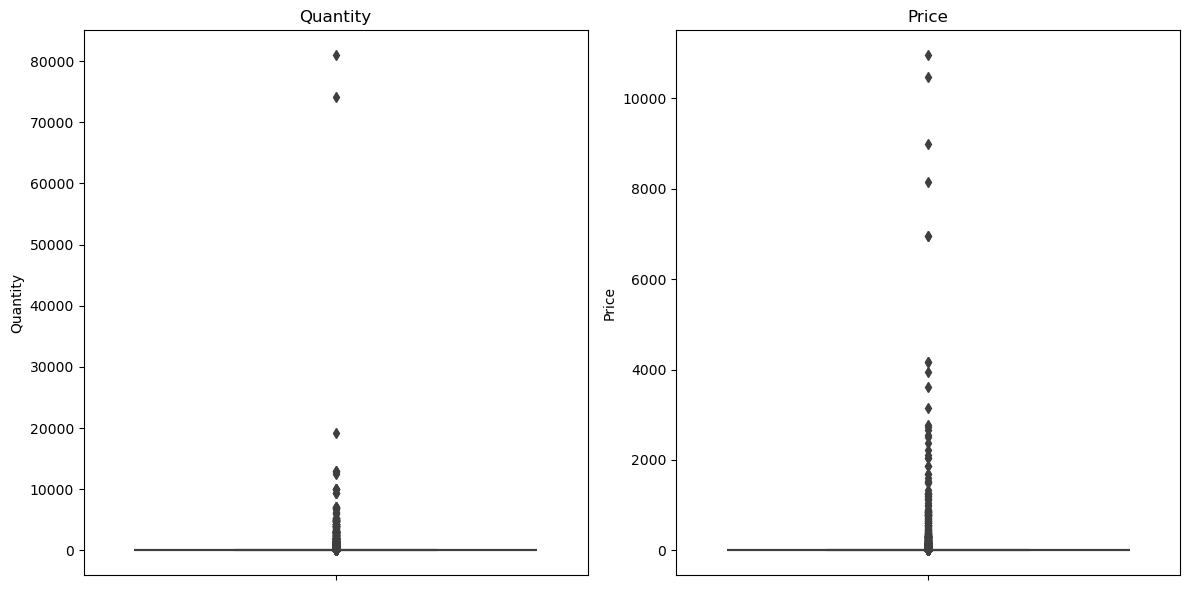

In [57]:
plt.figure(figsize=(12, 6))

# Creating a boxplot for Quantity
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Quantity'])
plt.title('Quantity')

# Creating a boxplot for Price
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price'])
plt.title('Price')

# Displaying the plot
plt.tight_layout()
plt.show()

In [58]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [59]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [60]:
df["InvoiceDate"].max(), df["InvoiceDate"].min()

(Timestamp('2011-12-09 12:50:00'), Timestamp('2009-12-01 07:45:00'))

In [61]:
today_date = dt.datetime(2011, 12, 11)

In [62]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]


# Filters out customers who have made more than one purchase
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

# Converts recency and T from days to weeks for easier interpretation
cltv_df["recency"] = cltv_df["recency"] / 7

cltv_df["T"] = cltv_df["T"] / 7

In [63]:
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,57.1429,103.7143,12,58.6750
12347.0000,57.4286,57.8571,8,704.1650
12348.0000,51.7143,62.7143,5,398.3720
12349.0000,81.4286,84.2857,4,946.6250
12352.0000,50.8571,56.1429,10,209.8940
...,...,...,...,...
18281.0000,56.7143,82.5714,2,100.5700
18282.0000,16.8571,18.1429,2,89.0250
18283.0000,93.4286,94.1429,22,124.3932


In [64]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.24, alpha: 11.24, b: 3.06, r: 1.71>

In [65]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
14911.0000   3.4132
12748.0000   2.8943
17841.0000   1.8170
15311.0000   1.7910
13089.0000   1.7474
14606.0000   1.6575
14156.0000   1.3320
14646.0000   1.3041
18102.0000   1.2524
13694.0000   1.2373
dtype: float64

In [67]:
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
14911.0000   3.4132
12748.0000   2.8943
17841.0000   1.8170
15311.0000   1.7910
13089.0000   1.7474
14606.0000   1.6575
14156.0000   1.3320
14646.0000   1.3041
18102.0000   1.2524
13694.0000   1.2373
dtype: float64

In [68]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [69]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [70]:
cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

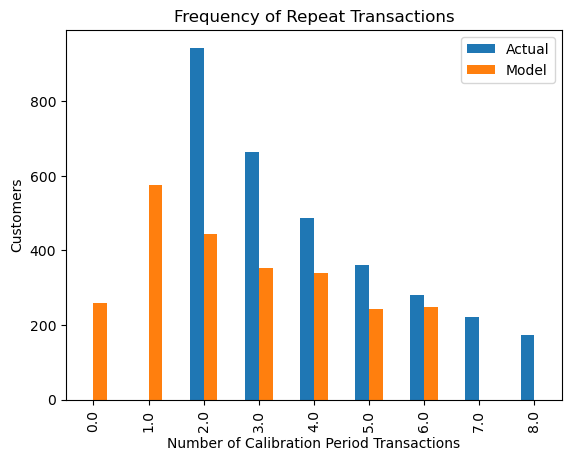

In [71]:
plot_period_transactions(bgf)
plt.show()

In [72]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 4255 subjects, p: 3.80, q: 0.34, v: 3.74>

In [73]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12357.0000,50.7143,55.5714,3,5824.8667,0.0660,0.2629,0.7793,6182.8322
12590.0000,0.0000,30.2857,2,4597.6125,0.0106,0.0419,0.1236,5035.2460
12415.0000,71.8571,75.4286,28,5003.3098,0.3332,1.3277,3.9433,5034.5651
14091.0000,6.2857,99.8571,2,4562.8450,0.0006,0.0024,0.0071,4997.1846
14088.0000,58.5714,60.2857,16,3986.0988,0.2424,0.9650,2.8607,4029.9276
18102.0000,105.4286,105.5714,145,3726.6687,1.2524,4.9945,14.8687,3731.1484
12753.0000,48.4286,51.8571,6,3571.5650,0.1168,0.4646,1.3760,3678.2984
12409.0000,69.4286,80.8571,7,3345.6129,0.0873,0.3478,1.0340,3430.9834
15749.0000,13.8571,47.5714,3,3231.7133,0.0223,0.0889,0.2631,3430.9068


In [74]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 months
                                   freq="W",  # Frequency of (weekly).
                                   discount_rate=0.01)

In [75]:
cltv = cltv.reset_index()

cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [76]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
4139,18102.0000,105.4286,105.5714,145,3726.6687,1.2524,4.9945,14.8687,3731.1484,59022.9051
1652,14646.0000,105.0000,105.4286,151,3361.4186,1.3041,5.2010,15.4834,3365.3009,55436.1993
1290,14156.0000,104.0000,105.5714,156,1903.5948,1.3320,5.3121,15.8141,1905.7332,32063.4678
1840,14911.0000,105.2857,105.5714,398,709.3988,3.4132,13.6120,40.5224,709.7169,30597.3079
3682,17450.0000,61.2857,62.7143,51,3334.3318,0.7029,2.7988,8.2981,3345.7601,29523.8465
1247,14096.0000,13.8571,14.5714,17,3163.4965,0.7071,2.7932,8.1358,3196.2592,27600.9279
51,12415.0000,71.8571,75.4286,28,5003.3098,0.3332,1.3277,3.9433,5034.5651,21115.8852
949,13694.0000,104.4286,105.1429,143,1338.7443,1.2373,4.9344,14.6894,1340.3929,20947.8726
3728,17511.0000,104.8571,105.4286,60,2924.4313,0.5257,2.0967,6.2421,2932.9545,19477.9350
3114,16684.0000,104.0000,104.7143,55,2513.8125,0.4858,1.9373,5.7672,2521.8167,15473.3025
